In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# 1. Data Loading and Initial Feature Engineering ---
try:
    df = pd.read_csv('ecommerce_dataset.csv')
except FileNotFoundError:
    print("Error: 'ecommerce_dataset.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# Create the target variable: Revenue = price * units_sold
df['Revenue'] = df['price'] * df['units_sold']
# Define features (X) and target (y)
# Drop 'product_id', 'product_name' (too many unique values), and 'units_sold' (target leakage)
X = df.drop(columns=['product_id', 'product_name', 'units_sold', 'Revenue'])
y = df['Revenue']

# Convert 'in_stock' boolean to integer (0 or 1)
X['in_stock'] = X['in_stock'].astype(int)

In [10]:
# 2. Preprocessing (One-Hot Encoding) ---

# Apply One-Hot Encoding to the 'category' column
X = pd.get_dummies(X, columns=['category'], drop_first=True)

In [12]:
# 3. Data Splitting ---

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Data successfully split into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples) sets.")
print("-" * 50)

Data successfully split into training (800 samples) and testing (200 samples) sets.
--------------------------------------------------


In [14]:
# 4. Model Training ---

# Initialize the models
rf_model = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42, n_jobs=-1)
xgb_model = XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1, objective='reg:squarederror')

# Train the models
print("Training Random Forest Regressor...")
rf_model.fit(X_train, y_train)

print("Training XGBoost Regressor...")
xgb_model.fit(X_train, y_train)
print("Training complete.")
print("-" * 50)

Training Random Forest Regressor...
Training XGBoost Regressor...
Training complete.
--------------------------------------------------


In [16]:
# 5. Model Evaluation ---

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"--- {model_name} Metrics ---")
    print(f"  RMSE (Root Mean Squared Error): ${rmse:,.2f}")
    print(f"  MAE (Mean Absolute Error): ${mae:,.2f}")
    print(f"  R-squared (R2): {r2:.4f}")
    print("-" * 50)
    return rmse
    # Evaluate both models
rf_rmse = evaluate_model(rf_model, X_test, y_test, "Random Forest")
xgb_rmse = evaluate_model(xgb_model, X_test, y_test, "XGBoost")

# Select the best model based on RMSE
if xgb_rmse < rf_rmse:
    best_model = xgb_model
    best_model_name = "XGBoost Regressor"
else:
    best_model = rf_model
    best_model_name = "Random Forest Regressor"
    print(f"The selected best model is the: {best_model_name}")
print("-" * 50)

--- Random Forest Metrics ---
  RMSE (Root Mean Squared Error): $133,957.56
  MAE (Mean Absolute Error): $97,408.12
  R-squared (R2): 0.3947
--------------------------------------------------
--- XGBoost Metrics ---
  RMSE (Root Mean Squared Error): $137,250.83
  MAE (Mean Absolute Error): $98,613.51
  R-squared (R2): 0.3645
--------------------------------------------------
The selected best model is the: Random Forest Regressor
--------------------------------------------------



--- Top 5 Feature Importances (Analyzing Purchase Patterns) ---
| Feature          | Importance   |
|:-----------------|:-------------|
| price            | 0.761748     |
| rating           | 0.18503      |
| category_Fashion | 0.0293391    |
| in_stock         | 0.0238824    |

Feature Importance chart saved as 'feature_importance.png'


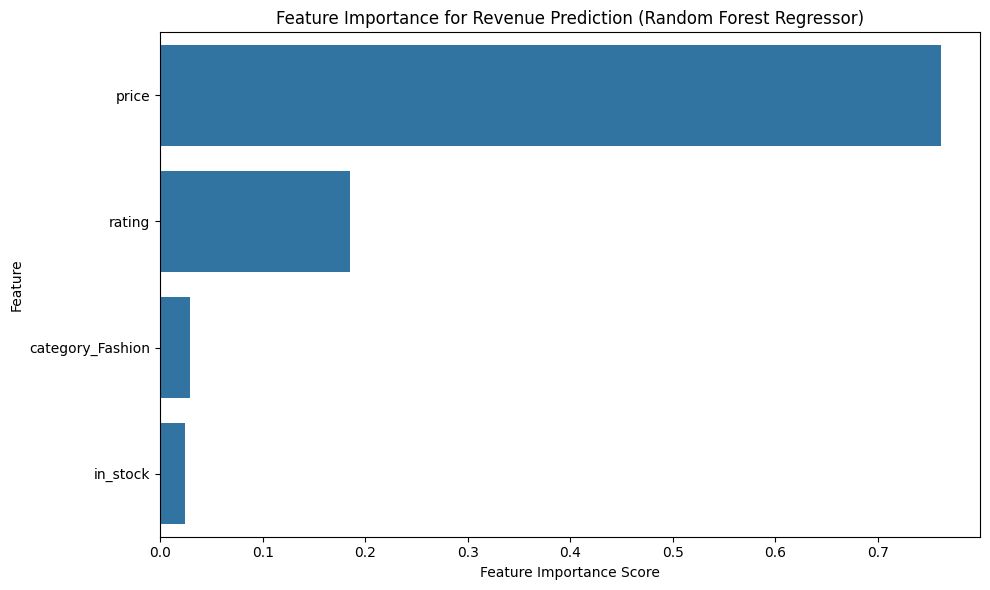

In [17]:
# --- 6. Feature Importance ---

# Get Feature Importance from the best model
importance = best_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print("\n--- Top 5 Feature Importances (Analyzing Purchase Patterns) ---")
print(feature_importance_df.head().to_markdown(index=False, numalign="left", stralign="left"))

# Optional: Plotting Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title(f'Feature Importance for Revenue Prediction ({best_model_name})')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance.png')
print("\nFeature Importance chart saved as 'feature_importance.png'")